Simple implementation of MNIST with TAP-SGM

In [2]:
import numpy as np
import os
import argparse
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from models.unet import UNet

In [3]:
## FFJORD things
import lib.layers as layers
import lib.utils as utils
import lib.odenvp as odenvp
import lib.multiscale_parallel as multiscale_parallel

from train_misc import standard_normal_logprob
from train_misc import set_cnf_options, count_nfe, count_parameters, count_total_time
from train_misc import add_spectral_norm, spectral_norm_power_iteration
from train_misc import create_regularization_fns, get_regularization, append_regularization_to_log


In [4]:
def ffjord_create_model(args, data_shape, regularization_fns):
    hidden_dims = tuple(map(int, args.dims.split(",")))
    strides = tuple(map(int, args.strides.split(",")))

    if args.multiscale:
        model = odenvp.ODENVP(
            (args.batch_size, *data_shape),
            n_blocks=args.num_blocks,
            intermediate_dims=hidden_dims,
            nonlinearity=args.nonlinearity,
            alpha=args.alpha,
            cnf_kwargs={"T": args.time_length, "train_T": args.train_T, "regularization_fns": regularization_fns},
        )
    elif args.parallel:
        model = multiscale_parallel.MultiscaleParallelCNF(
            (args.batch_size, *data_shape),
            n_blocks=args.num_blocks,
            intermediate_dims=hidden_dims,
            alpha=args.alpha,
            time_length=args.time_length,
        )
    else:
        if args.autoencode:

            def build_cnf():
                autoencoder_diffeq = layers.AutoencoderDiffEqNet(
                    hidden_dims=hidden_dims,
                    input_shape=data_shape,
                    strides=strides,
                    conv=args.conv,
                    layer_type=args.layer_type,
                    nonlinearity=args.nonlinearity,
                )
                odefunc = layers.AutoencoderODEfunc(
                    autoencoder_diffeq=autoencoder_diffeq,
                    divergence_fn=args.divergence_fn,
                    residual=args.residual,
                    rademacher=args.rademacher,
                )
                cnf = layers.CNF(
                    odefunc=odefunc,
                    T=args.time_length,
                    regularization_fns=regularization_fns,
                    solver=args.solver,
                )
                return cnf
        else:

            def build_cnf():
                diffeq = layers.ODEnet(
                    hidden_dims=hidden_dims,
                    input_shape=data_shape,
                    strides=strides,
                    conv=args.conv,
                    layer_type=args.layer_type,
                    nonlinearity=args.nonlinearity,
                )
                odefunc = layers.ODEfunc(
                    diffeq=diffeq,
                    divergence_fn=args.divergence_fn,
                    residual=args.residual,
                    rademacher=args.rademacher,
                )
                cnf = layers.CNF(
                    odefunc=odefunc,
                    T=args.time_length,
                    train_T=args.train_T,
                    regularization_fns=regularization_fns,
                    solver=args.solver,
                )
                return cnf

        chain = [layers.LogitTransform(alpha=args.alpha)] if args.alpha > 0 else [layers.ZeroMeanTransform()]
        chain = chain + [build_cnf() for _ in range(args.num_blocks)]
        if args.batch_norm:
            chain.append(layers.MovingBatchNorm2d(data_shape[0]))
        model = layers.SequentialFlow(chain)
    return model

In [5]:
# import MNIST samples

transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST('mnist_data',train = True,download = True, transform = transform)



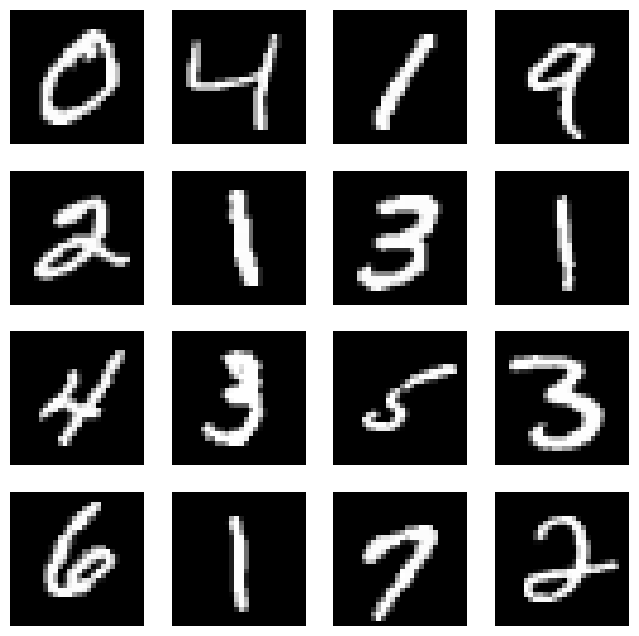

In [6]:
nrows = 4
ncols = 4
fig = plt.figure(figsize=(8,8))
i = 1
for a in range(nrows):
    for b in range(ncols):
        fig.add_subplot(nrows,ncols,i)
        plt.imshow(dataset[i][0][0],cmap = 'gray')
        i = i+1
        plt.axis('off')


In [5]:
## Load preconditioning map

inputchannels = 1
inputheight = 28
dimx = inputchannels * inputheight ** 2

checkpoint = torch.load('ffjord_mnist_bad_checkpt.pth',map_location = torch.device('cpu'))
preconditionerargs = checkpoint['args']

data_shape = (inputchannels, inputheight, inputheight)

regularization_fns, regularization_coeffs = create_regularization_fns(preconditionerargs)
model = ffjord_create_model(preconditionerargs,data_shape,regularization_fns)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cvt = lambda x: x.type(torch.float32).to(device, non_blocking=True)
fixed_z = cvt(torch.randn(16, *data_shape))

ffjord_generated_samples = model(fixed_z, reverse=True).view(-1, *data_shape)


/Users/bjzhang/gitrepos/tap-sgm/mymnist/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


KeyboardInterrupt: 

In [9]:
## Pushforward samples

In [11]:
loader = torch.utils.data.DataLoader(dataset,1)
blah = enumerate(loader)
a, (blah,b) = next(blah)

pushforward_z = model(blah,reverse = False).view(-1,*data_shape)

In [12]:
pushforward_z.shape
bleh = pushforward_z.detach().numpy()
bleh[4,:,1,1]
plt.scatter(bleh[:,0,14,10],bleh[:,0,4,1])

IndexError: index 4 is out of bounds for axis 0 with size 1

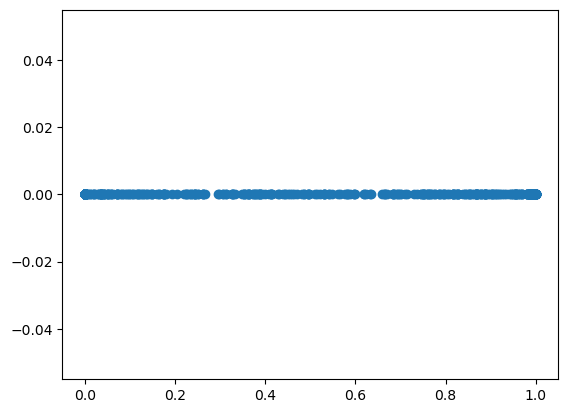

In [157]:
scattersamples = blah.detach().numpy()

plt.scatter(scattersamples[:,0,14,10],scattersamples[:,0,4,1])

In [114]:
# Scorenet is a U-net, whatever that is. 

## FIGURE OUT SCORENET NEXT

## THEN FIGURE OUT THE PRETRAINED THING

##LOOK AT 2D MARGINALS OF THE BAD FFJORDMAP

## Define scorenetwork 

inputchannels = 1
inputheight = 28
dimx = inputchannels * inputheight ** 2


scorenet = UNet(input_channels = inputchannels,
                input_height = inputheight,
                ch = 32,
                ch_mult = (1,2,2),
                num_res_blocks=2,
                attn_resolutions=(16,),
                resamp_with_conv=True,
                )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scorenet = scorenet.to(device)


In [115]:
# Train the scorenet

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor,Tmin,Tmax,eps) -> torch.Tensor:
    # x: (batch_size, nch) is the training data
    
    # sample the time
    t = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * (Tmax-Tmin+eps)

    # calculate the terms for the posterior log distribution

    sigmas = torch.sqrt(1 - torch.exp(-t))
    noise = torch.randn_like(x) * sigmas

    perturbed_samples = x*torch.exp(-0.5 * t) + noise

    target = - 1/(sigmas ** 2) * noise

    scores = score_network(perturbed_samples,t.squeeze())

    target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores-target)**2)

    return (loss.view(x.size(0), -1).sum(1, keepdim=False)).mean()

    # int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    # mu_t = x * torch.exp(-0.5 * int_beta)
    # var_t = -torch.expm1(-int_beta)
    # x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    # grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # # calculate the score function
    # score = score_network(x_t, t)  # score: (batch_size, nch)

    # # calculate the loss function
    # loss = (score - grad_log_p) ** 2
    # lmbda_t = var_t
    # weighted_loss = lmbda_t * loss
    # return torch.mean(weighted_loss)

In [116]:
## training
scorenet.train()
opt = torch.optim.Adam(scorenet.parameters(),lr = 0.001)

epochs = 10000
for step in range(epochs):

    opt.zero_grad()
    randind = torch.randint(0,10000,(64,))
    data = torch.tensor(loaded[randind,:,:,:])

    # training step
    loss = calc_loss(scorenet, data,0,1,1e-4)
    loss.backward()
    opt.step()
    print(loss)


KeyboardInterrupt: 

In [175]:
score_network()

tensor(2816.9033, grad_fn=<MeanBackward0>)

In [130]:
bleh = scorenet(b,torch.tensor([1,2]).squeeze())
bleh.size()


torch.Size([2, 1, 28, 28])

In [127]:
scorenet_trained = torch.load('mnist_scorenet_tapsgm_ffjord_T2_lr001_iter100k_strongprior',map_location=torch.device('cpu'))

In [128]:
def ou_process(x,T):


    sigmas = torch.sqrt(1 - torch.exp(-torch.tensor(T)))
    noise = torch.randn_like(x) * sigmas

    perturbed_samples = x*torch.exp(-0.5 * T) + noise
    return perturbed_samples


def generate_samples(score_network: torch.nn.Module, nsamples: int,loaded) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn_like(loaded[0:16,:,:,:], device=device)  # (nsamples, nch)
    time_pts = torch.linspace(2, 0, 1000, device=device)  # (ntime_pts,)
    # beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5  * x_t
        gt = 1
        score = -x_t + score_network(x_t, t.expand(x_t.shape[0], 1).squeeze()).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t - drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

/var/folders/p0/n1jqqn2d77l8cmp6krhtzwqh0000gr/T/ipykernel_57251/577141361.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmas = torch.sqrt(1 - torch.exp(-torch.tensor(T)))


(-4.208838748931885, 6.529947757720948, -5.87062635421753, 4.868160152435303)

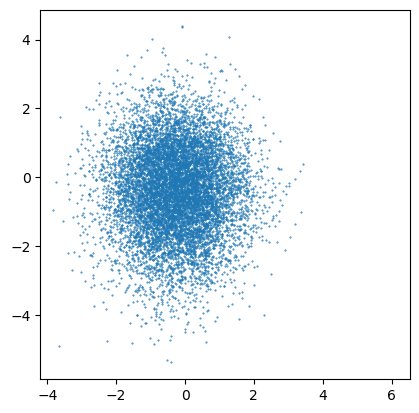

In [109]:
loaded = torch.load('pushforward_samples')
loaded = loaded.detach().numpy()

evolve = ou_process(torch.tensor(loaded),torch.tensor(2))


plt.scatter(evolve[0:10000,0,9,1],evolve[0:10000,0,1,23],s = 0.2)
plt.axis('square')


In [129]:
generated_samps = generate_samples(scorenet_trained,2,torch.tensor(loaded))


In [130]:
test = model(generated_samps[:,:,:,:],reverse = True)



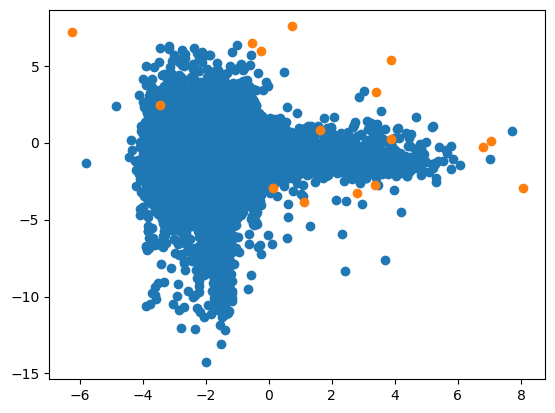

In [139]:
# generated_samps = generated_samps.detach().numpy()
plt.scatter(preprocessed[:,0,4,1],preprocessed[:,0,2,2])
plt.scatter(generated_samps[:,0,4,1],generated_samps[:,0,2,2])


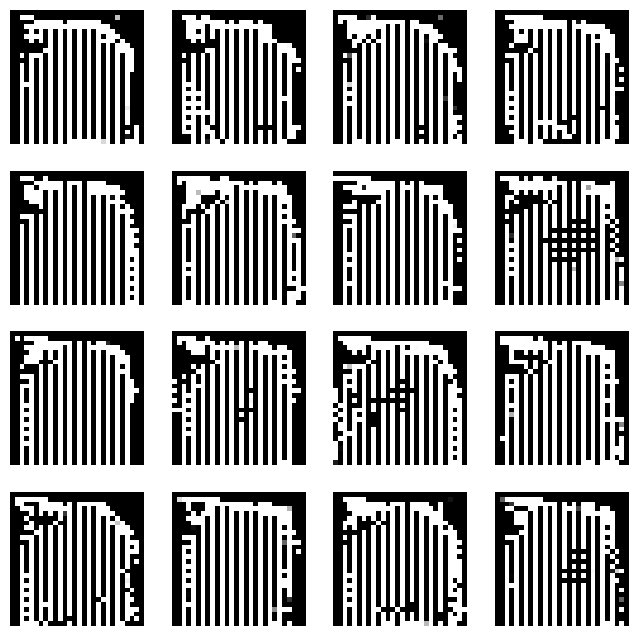

In [131]:
# plt.imshow(test[13,0,:,:].detach().numpy(),cmap = 'gray')

nrows = 4
ncols = 4
fig = plt.figure(figsize=(8,8))
i = 0
for a in range(nrows):
    for b in range(ncols):
        fig.add_subplot(nrows,ncols,i+1)
        plt.imshow(test[i,0,:,:].detach().numpy(),cmap = 'gray')
        i = i+1
        plt.axis('off')


In [100]:
x = torch.tensor(loaded )
t = torch.rand([x.size(0), ] + [1 for _ in range(x.ndim - 1)]).to(x) * (2)


In [42]:
preprocessed = torch.load('pushforward_samples').detach().numpy()

(-12.606188297271729, 9.47881031036377, -14.236348390579224, 7.848650217056274)

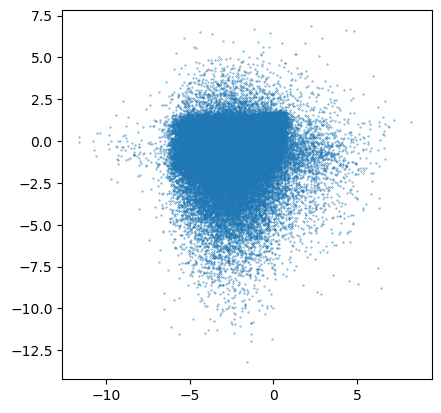

In [57]:
plt.scatter(preprocessed[:,0,19,21],preprocessed[:,0,5,10],s = 0.1)
plt.axis('square')